In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def bin_lot_area(lotarea):
    
    """
    Put LotArea values in bins, used for imputing missing LotFrontage values
    """
    
    if lotarea <= 5000: lotareabinned = 2500
    elif (lotarea > 5000 and lotarea <= 10000): lotareabinned= 7500
    elif (lotarea > 10000 and lotarea <= 15000): lotareabinned = 12500
    elif (lotarea > 15000 and lotarea <= 20000): lotareabinned=17500
    elif (lotarea > 20000): lotareabinned = 25000
    return lotareabinned


In [3]:
def fill_lot_frontage(lotfrontage, lotareabinnedtemp, mean_lot_frontage): # don't actually need last arg to be defined in function - it's global
    
    """
    Fill missing LotFrintage values based on mean LotFrontage values (of existing vals) in the created LotArea bins
    """
    
    if not pd.isnull(lotfrontage): lotfrontage = lotfrontage
    else: lotfrontage = mean_lot_frontage[lotareabinnedtemp]
    return lotfrontage


In [4]:
def fill_basement_nan(bsmtvalues):
    
    """
    Require all basement values for a row to be NaN to be sure that NaN means no basement present
    Then replace NaN with 'UN'
    """
    
    if (pd.isnull(bsmtvalues['BsmtQual']) and pd.isnull(bsmtvalues['BsmtCond']) and 
        pd.isnull(bsmtvalues['BsmtExposure']) and pd.isnull(bsmtvalues['BsmtFinType1']) and
        pd.isnull(bsmtvalues['BsmtFinType2'])):
        
        bsmtvalues['BsmtQual'] = "UN"
        bsmtvalues['BsmtCond'] = "UN"
        bsmtvalues['BsmtExposure'] = "UN"
        bsmtvalues['BsmtFinType1'] = "UN"
        bsmtvalues['BsmtFinType2'] = "UN"
        
    return bsmtvalues


In [5]:
def fill_garage_nan(garagevalues):
    
    """
    Fill missing garage values that are set to NaN if no garage present (GarageArea = 0)
    So rename NaN as 'UN' if GarageArea == 0
    """
    
    if garagevalues['GarageArea'] == 0:
        garagevalues['GarageType'] = "UN"
        garagevalues['GarageYrBlt'] = "UN"
        garagevalues['GarageFinish'] = "UN"
        garagevalues['GarageQual'] = "UN"
        garagevalues['GarageCond'] = "UN"
        
    return garagevalues

In [309]:
def process_housing_df(df, datatype='train'):
    
    """
    Principal function for feature engineering
    """
    
    # remove cols with too many missing features
    df.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
    
    # impute missing LotFrontage values based on bins of LotArea (the two are correlated)
    df['LotAreaBinnedTemp'] = df['LotArea'].apply(bin_lot_area)
    mean_lot_frontage = df.groupby('LotAreaBinnedTemp').mean()['LotFrontage']
    df['LotFrontageTemp'] = df.apply(lambda x: fill_lot_frontage(x['LotFrontage'], x['LotAreaBinnedTemp'], mean_lot_frontage), axis=1)
    df.drop(['LotAreaBinnedTemp', 'LotFrontage'], axis=1, inplace=True)
    df.rename(columns={'LotFrontageTemp': 'LotFrontage'}, inplace=True)
    
    # not many null values for MasVnrType (and MasVnrArea) so drop their NaN values (only for train)
    if datatype == 'train': df.dropna(subset=['MasVnrType'], inplace=True)
    
    # impute missing basement values.  Those that are NaN mean no basement, so rename NaN to 'UN'
    df = df.apply(fill_basement_nan, axis=1)
    
    # impute missing garage values.  Those that are NaN (and if GarageArea==0) mean no garage, so rename NaN to 'UN'
    df = df.apply(fill_garage_nan, axis=1)
    
    # Drop the final few missing values (only for train - if test, set to 0)
    if datatype == 'train': df.dropna(inplace=True)
    elif datatype == 'test': df.fillna(0, inplace=True)
    
    # Remove predictors that only would have if made sale (data leakage)
    df.drop(['YrSold','MoSold','SaleType','SaleCondition'], axis=1, inplace=True)
    
    # Remove categorical variables that are not really correlated with SalePrice
    df.drop(['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 
            'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 
            'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
            'Heating', 'CentralAir', 'Electrical', 'Functional', 
            'GarageType', 'GarageYrBlt', 'GarageQual', 'GarageCond', 'PavedDrive', 'ExterCond'], axis=1, inplace=True)
    
    # Set remaining categorical variables to dummies, dropFirst, and drop original
    dummies = pd.get_dummies(data=df[['MSZoning','MasVnrType','ExterQual','BsmtQual','HeatingQC','KitchenQual','GarageFinish']], drop_first=True)
    df = pd.concat([df.drop(['MSZoning','MasVnrType','ExterQual','BsmtQual','HeatingQC','KitchenQual','GarageFinish'], axis=1), dummies], axis=1)

    # Remove continuous variables that are not really correlated with SalePrice
    df.drop(['MSSubClass', 'LotArea', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 
            'HalfBath', 'KitchenAbvGr', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
              axis=1, inplace=True)
    
    return df

## MAIN

In [7]:
df_train = pd.read_csv('train.csv', index_col='Id')
df_train = process_housing_df(df_train)

In [8]:
len(df_train)

1449

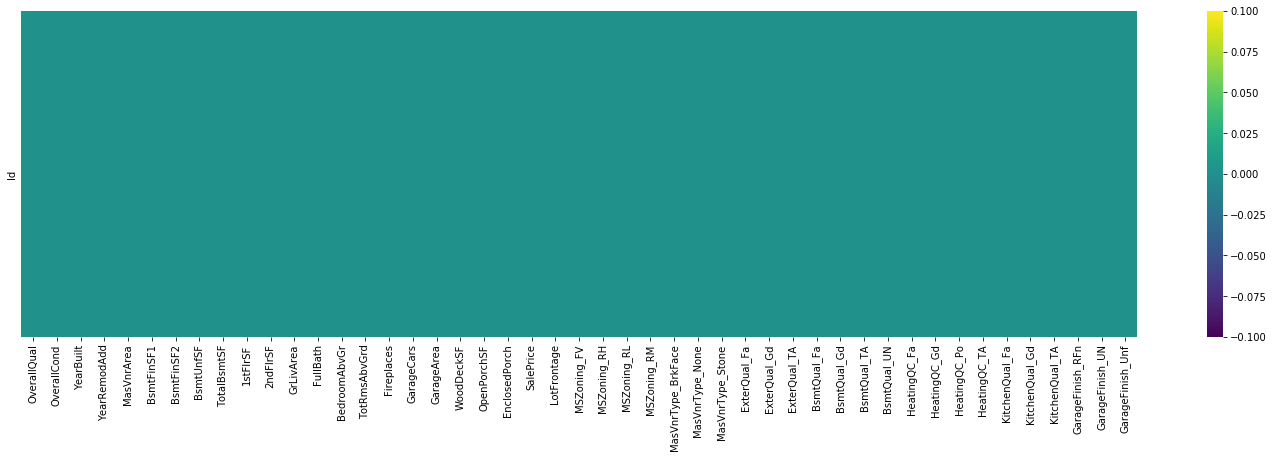

In [9]:
fig = plt.figure(figsize=(25,6))
sns.heatmap(df_train.isnull(), annot=False, yticklabels=False, cmap='viridis')

In [28]:
#sns.pairplot(df_train)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 1 to 1460
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OverallQual         1449 non-null   int64  
 1   OverallCond         1449 non-null   int64  
 2   YearBuilt           1449 non-null   int64  
 3   YearRemodAdd        1449 non-null   int64  
 4   MasVnrArea          1449 non-null   float64
 5   BsmtFinSF1          1449 non-null   int64  
 6   BsmtFinSF2          1449 non-null   int64  
 7   BsmtUnfSF           1449 non-null   int64  
 8   TotalBsmtSF         1449 non-null   int64  
 9   1stFlrSF            1449 non-null   int64  
 10  2ndFlrSF            1449 non-null   int64  
 11  GrLivArea           1449 non-null   int64  
 12  FullBath            1449 non-null   int64  
 13  BedroomAbvGr        1449 non-null   int64  
 14  TotRmsAbvGrd        1449 non-null   int64  
 15  Fireplaces          1449 non-null   int64  
 16  Garage

# Do TrainTestSplit on Training data

In [12]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('SalePrice', axis=1), df_train['SalePrice'], 
                                                    test_size=0.33, random_state=101) 

# First try linear regression

In [16]:
from sklearn.linear_model import LinearRegression

In [18]:
linear_model = LinearRegression()

In [19]:
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
linear_prediction = linear_model.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [26]:
print("MEAN ABS ERROR:", mean_absolute_error(y_test, linear_prediction))
print("MEAN SQ ERROR:", mean_squared_error(y_test, linear_prediction))
print("MEAN RMS ERROR:", np.sqrt(mean_squared_error(y_test, linear_prediction)))

MEAN ABS ERROR: 20180.648004369792
MEAN SQ ERROR: 769960712.0046461
MEAN RMS ERROR: 27748.16592145589


Text(0, 0.5, 'Predicted cost ($)')

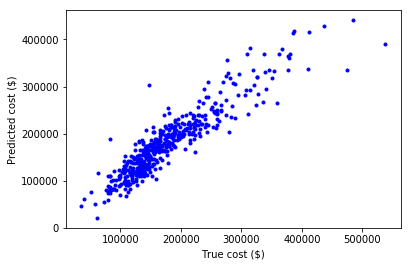

In [30]:
plt.plot(y_test, linear_prediction, 'b.')
plt.xlabel('True cost ($)')
plt.ylabel('Predicted cost ($)')

In [35]:
linear_df = pd.DataFrame({'Predicted cost': linear_prediction, 'True cost': y_test})

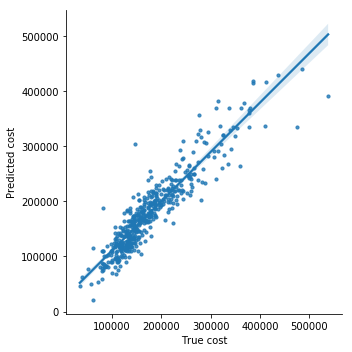

In [41]:
sns.lmplot(data=linear_df, x='True cost', y='Predicted cost', scatter_kws={'s':10})

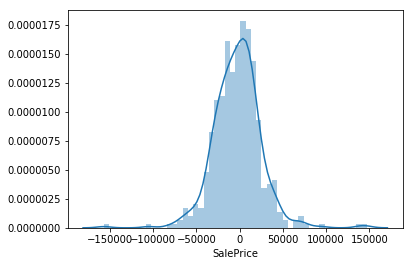

In [43]:
sns.distplot(y_test-linear_prediction, bins=50)

In [51]:
lm_coef = pd.DataFrame(linear_model.coef_, X_test.columns, columns=['Coefficient'])

In [52]:
lm_coef

Coefficient
OverallQual         12481.950211
OverallCond          7109.418934
YearBuilt             210.999215
YearRemodAdd          -63.616818
MasVnrArea             49.641744
BsmtFinSF1              4.413218
BsmtFinSF2             10.573186
BsmtUnfSF              -5.802954
TotalBsmtSF             9.183451
1stFlrSF               46.863802
2ndFlrSF               39.755317
GrLivArea              -6.476601
FullBath             3263.975795
BedroomAbvGr        -2697.160797
TotRmsAbvGrd         2291.098606
Fireplaces           7212.666798
GarageCars          18484.146792
GarageArea             -3.005115
WoodDeckSF             25.112667
OpenPorchSF           -14.710349
EnclosedPorch          13.888334
LotFrontage           -37.309160
MSZoning_FV         19439.897797
MSZoning_RH          7439.449249
MSZoning_RL         19878.434950
MSZoning_RM          4537.516463
MasVnrType_BrkFace   6505.217557
MasVnrType_None     19880.536305
MasVnrType_Stone    11448.307246
ExterQual_Fa        -7338.387295
ExterQual_Gd        -4705.616062
ExterQual_TA       -16201.676756
BsmtQual_Fa        -50421.475995
BsmtQual_Gd        -41709.637525
BsmtQual_TA        -44236.579992
BsmtQual_UN        -53683.978142
HeatingQC_Fa        -5465.140251
HeatingQC_Gd        -5035.694509
HeatingQC_Po       -23065.104125
HeatingQC_TA        -6747.315874
KitchenQual_Fa     -25965.035293
KitchenQual_Gd     -27530.597227
KitchenQual_TA     -30436.895327
GarageFinish_RFn    -2110.733514
GarageFinish_UN     15419.397504
GarageFinish_Unf    -4559.742532

# Now try KNN Regressor

In [55]:
from sklearn.preprocessing import StandardScaler

In [57]:
standard_scaler = StandardScaler()

In [59]:
standard_scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [63]:
# scale according to training set on both training and test set features
standard_scaled_features_train = standard_scaler.transform(X_train)
standard_scaled_features_test  = standard_scaler.transform(X_test)

In [53]:
from sklearn.neighbors import KNeighborsRegressor

In [96]:
# now choose k value
error_rate = []

for i in range(1, 100):
    knn_i = KNeighborsRegressor(n_neighbors=i)
    knn_i.fit(standard_scaled_features_train, y_train)
    knn_i_prediction = knn_i.predict(standard_scaled_features_test)
    error_rate.append(np.sqrt(mean_squared_error(y_test, knn_i_prediction)))

Text(0, 0.5, 'Mean squared error')

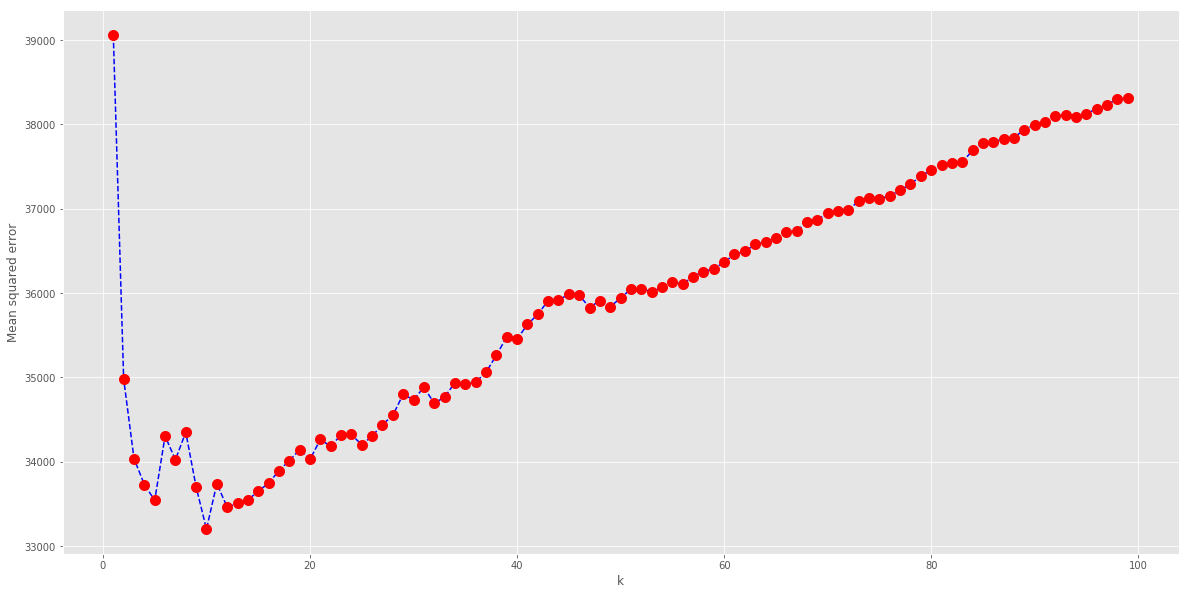

In [97]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
plt.plot(range(1,100), error_rate, 
         color='blue', ls='dashed', marker='o', ms=10, markerfacecolor='red', markeredgecolor='red')
plt.xlabel('k')
plt.ylabel('Mean squared error')

In [89]:
# Best is k = 10, ar just over $33,000 diff.  This is worse than linear regression at $28,000 diff

# Now try random forest

In [90]:
# No need for scaling here
from sklearn.ensemble import RandomForestRegressor

In [109]:
error_rate_rand_forest = []

for i in range(1, 200, 5):
    rforest_i = RandomForestRegressor(n_estimators=i)
    rforest_i.fit(X_train, y_train)
    rforest_i_prediction = rforest_i.predict(X_test)
    error_rate_rand_forest.append(np.sqrt(mean_squared_error(y_test, rforest_i_prediction)))

Text(0, 0.5, 'Mean squared error')

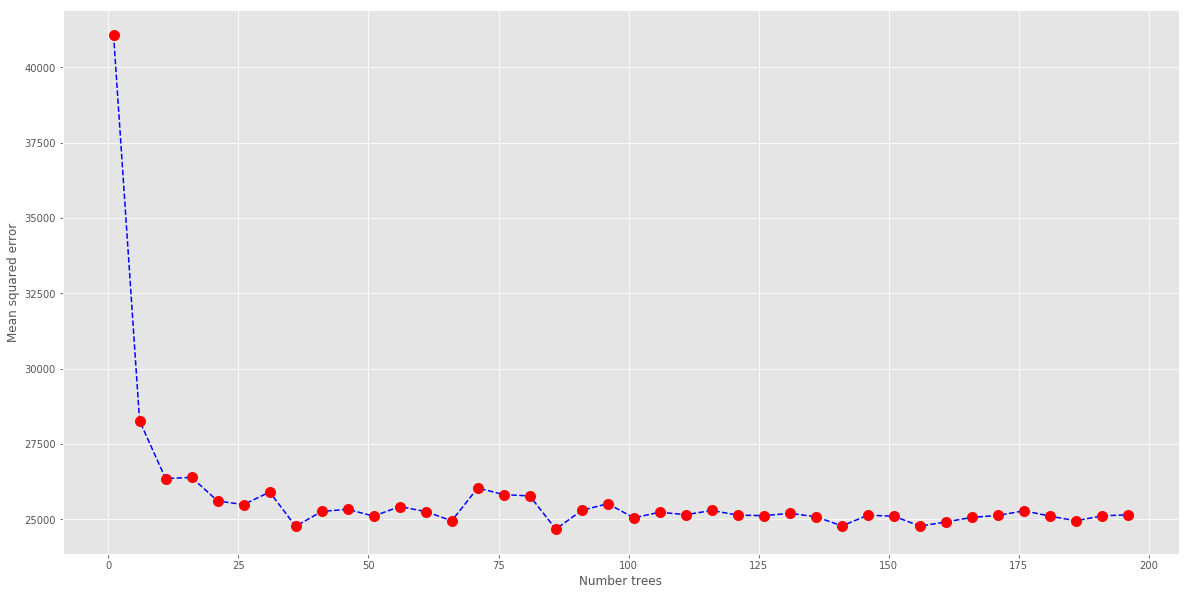

In [110]:
plt.figure(figsize=(20,10))
plt.plot(range(1,200,5), error_rate_rand_forest, 
         color='blue', ls='dashed', marker='o', ms=10, markerfacecolor='red', markeredgecolor='red')
plt.xlabel('Number trees')
plt.ylabel('Mean squared error')

In [111]:
# best so far around 36 trees at $25000 mean sq error

# Now try Support Vector Machine

In [113]:
# use gridsearch to find best params

In [120]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [146]:
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

In [147]:
grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=3)
grid.fit(standard_scaled_features_train, y_train)

/home/robertv/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=0.0001, score=-0.058, total=   0.1s
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=0.0001, score=-0.043, total=   0.1s
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=0.0001, score=-0.022, total=   0.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ................. C=0.1, gamma=0.001, score=-0.058, total=   0.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ................. C=0.1, gamma=0.001, score=-0.042, total=   0.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ................. C=0.1, gamma=0.001, score=-0.022, total=   0.1s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ..........

[CV] ..................... C=100, gamma=1, score=-0.022, total=   0.1s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ............... C=1000, gamma=0.0001, score=-0.037, total=   0.1s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ............... C=1000, gamma=0.0001, score=-0.023, total=   0.0s
[CV] C=1000, gamma=0.0001 ............................................
[CV] ............... C=1000, gamma=0.0001, score=-0.003, total=   0.1s
[CV] C=1000, gamma=0.001 .............................................
[CV] ................. C=1000, gamma=0.001, score=0.109, total=   0.1s
[CV] C=1000, gamma=0.001 .............................................
[CV] ................. C=1000, gamma=0.001, score=0.117, total=   0.1s
[CV] C=1000, gamma=0.001 .............................................
[CV] ................. C=1000, gamma=0.001, score=0.146, total=   0.1s
[CV] C=1000, gamma=0.01 ..............................................
[CV] .

[CV] .................. C=1000000, gamma=1, score=0.014, total=   0.1s
[CV] C=1000000, gamma=1 ..............................................
[CV] .................. C=1000000, gamma=1, score=0.014, total=   0.1s


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    8.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [193]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)
svc_prediction = grid.predict(standard_scaled_features_test)
print("MEAN RMS ERROR:", np.sqrt(mean_squared_error(y_test, svc_prediction)))

{'C': 100000, 'gamma': 0.01}
SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
0.8364439778928509
MEAN RMS ERROR: 24476.270335578574


Text(0, 0.5, 'Predicted cost ($)')

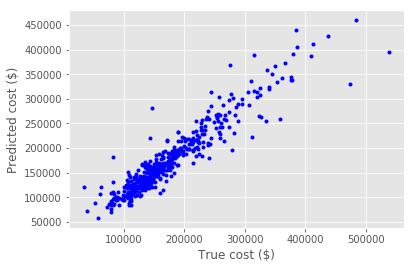

In [197]:
plt.plot(y_test, svc_prediction, 'b.')
plt.xlabel('True cost ($)')
plt.ylabel('Predicted cost ($)')

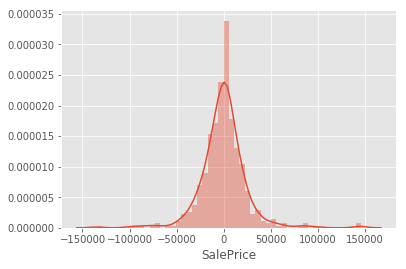

In [199]:
sns.distplot(y_test-svc_prediction, bins=50)

In [149]:
# Hmm it's okay - but C suspiciously large. Mean RMS error was even worse without scaling ($68,000)

# Try a Neural Network

In [150]:
from sklearn.preprocessing import MinMaxScaler

In [151]:
minmax_scaler = MinMaxScaler()

In [152]:
minmax_scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [154]:
minmax_scaled_features_train = minmax_scaler.transform(X_train)
minmax_scaled_features_test  = minmax_scaler.transform(X_test)

In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [184]:
NN_model = Sequential()

NN_model.add(Dense(47, activation='relu'))
NN_model.add(Dense(47, activation='relu'))
NN_model.add(Dense(47, activation='relu'))
NN_model.add(Dense(47, activation='relu'))
NN_model.add(Dense(1))

NN_model.compile(optimizer='adam', loss='mse')

In [185]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [186]:
NN_model.fit(x=minmax_scaled_features_train, y=y_train.values,
            validation_data=(minmax_scaled_features_test, y_test.values),
            callbacks=[early_stop],
            batch_size=128, epochs=600)

Epoch 1/600
8/8 [==============================] - 0s 10ms/step - loss: 40261496832.0000 - val_loss: 36092932096.0000
Epoch 2/600
8/8 [==============================] - 0s 4ms/step - loss: 40261226496.0000 - val_loss: 36092538880.0000
Epoch 3/600
8/8 [==============================] - 0s 4ms/step - loss: 40260644864.0000 - val_loss: 36091682816.0000
Epoch 4/600
8/8 [==============================] - 0s 4ms/step - loss: 40259420160.0000 - val_loss: 36089876480.0000
Epoch 5/600
8/8 [==============================] - 0s 5ms/step - loss: 40256753664.0000 - val_loss: 36085870592.0000
Epoch 6/600
8/8 [==============================] - 0s 4ms/step - loss: 40250822656.0000 - val_loss: 36077264896.0000
Epoch 7/600
8/8 [==============================] - 0s 5ms/step - loss: 40238665728.0000 - val_loss: 36059807744.0000
Epoch 8/600
8/8 [==============================] - 0s 10ms/step - loss: 40213987328.0000 - val_loss: 36026089472.0000
Epoch 9/600
8/8 [==============================] - 0s 5ms/step

8/8 [==============================] - 0s 4ms/step - loss: 2585642496.0000 - val_loss: 1920509184.0000
Epoch 72/600
8/8 [==============================] - 0s 4ms/step - loss: 2564182016.0000 - val_loss: 1901286912.0000
Epoch 73/600
8/8 [==============================] - 0s 9ms/step - loss: 2543259648.0000 - val_loss: 1884725504.0000
Epoch 74/600
8/8 [==============================] - 0s 5ms/step - loss: 2521257472.0000 - val_loss: 1875879936.0000
Epoch 75/600
8/8 [==============================] - 0s 4ms/step - loss: 2499448832.0000 - val_loss: 1859626240.0000
Epoch 76/600
8/8 [==============================] - 0s 5ms/step - loss: 2480537856.0000 - val_loss: 1841422848.0000
Epoch 77/600
8/8 [==============================] - 0s 4ms/step - loss: 2457833472.0000 - val_loss: 1828176000.0000
Epoch 78/600
8/8 [==============================] - 0s 8ms/step - loss: 2438020352.0000 - val_loss: 1810663552.0000
Epoch 79/600
8/8 [==============================] - 0s 4ms/step - loss: 2419176960.00

8/8 [==============================] - 0s 4ms/step - loss: 1642396800.0000 - val_loss: 1114532224.0000
Epoch 142/600
8/8 [==============================] - 0s 4ms/step - loss: 1636592768.0000 - val_loss: 1105320576.0000
Epoch 143/600
8/8 [==============================] - 0s 5ms/step - loss: 1629173760.0000 - val_loss: 1101653632.0000
Epoch 144/600
8/8 [==============================] - 0s 10ms/step - loss: 1622064000.0000 - val_loss: 1094133888.0000
Epoch 145/600
8/8 [==============================] - 0s 6ms/step - loss: 1616650112.0000 - val_loss: 1086394880.0000
Epoch 146/600
8/8 [==============================] - 0s 6ms/step - loss: 1609345152.0000 - val_loss: 1079725696.0000
Epoch 147/600
8/8 [==============================] - 0s 9ms/step - loss: 1604338688.0000 - val_loss: 1074757504.0000
Epoch 148/600
8/8 [==============================] - 0s 6ms/step - loss: 1599561856.0000 - val_loss: 1070528640.0000
Epoch 149/600
8/8 [==============================] - 0s 5ms/step - loss: 1593

8/8 [==============================] - 0s 5ms/step - loss: 1373865984.0000 - val_loss: 840963328.0000
Epoch 212/600
8/8 [==============================] - 0s 9ms/step - loss: 1373689728.0000 - val_loss: 842523520.0000
Epoch 213/600
8/8 [==============================] - 0s 4ms/step - loss: 1371034624.0000 - val_loss: 834660864.0000
Epoch 214/600
8/8 [==============================] - 0s 4ms/step - loss: 1369108736.0000 - val_loss: 831687936.0000
Epoch 215/600
8/8 [==============================] - 0s 4ms/step - loss: 1367947776.0000 - val_loss: 829508032.0000
Epoch 216/600
8/8 [==============================] - 0s 8ms/step - loss: 1364974464.0000 - val_loss: 826395264.0000
Epoch 217/600
8/8 [==============================] - 0s 5ms/step - loss: 1361298816.0000 - val_loss: 822657408.0000
Epoch 218/600
8/8 [==============================] - 0s 4ms/step - loss: 1359420288.0000 - val_loss: 820232960.0000
Epoch 219/600
8/8 [==============================] - 0s 5ms/step - loss: 1358013568.00

Epoch 282/600
8/8 [==============================] - 0s 5ms/step - loss: 1271364608.0000 - val_loss: 744849280.0000
Epoch 283/600
8/8 [==============================] - 0s 8ms/step - loss: 1272657024.0000 - val_loss: 742575424.0000
Epoch 284/600
8/8 [==============================] - 0s 4ms/step - loss: 1269052544.0000 - val_loss: 745317504.0000
Epoch 285/600
8/8 [==============================] - 0s 5ms/step - loss: 1264965376.0000 - val_loss: 750643584.0000
Epoch 286/600
8/8 [==============================] - 0s 4ms/step - loss: 1268240128.0000 - val_loss: 752751168.0000
Epoch 287/600
8/8 [==============================] - 0s 7ms/step - loss: 1267306752.0000 - val_loss: 741780864.0000
Epoch 288/600
8/8 [==============================] - 0s 4ms/step - loss: 1267580288.0000 - val_loss: 740320256.0000
Epoch 289/600
8/8 [==============================] - 0s 4ms/step - loss: 1263654656.0000 - val_loss: 742326400.0000
Epoch 290/600
8/8 [==============================] - 0s 4ms/step - loss:

8/8 [==============================] - 0s 5ms/step - loss: 1230874368.0000 - val_loss: 710684608.0000
Epoch 353/600
8/8 [==============================] - 0s 4ms/step - loss: 1221725952.0000 - val_loss: 724640704.0000
Epoch 354/600
8/8 [==============================] - 0s 4ms/step - loss: 1233546112.0000 - val_loss: 730189888.0000
Epoch 355/600
8/8 [==============================] - 0s 4ms/step - loss: 1234811008.0000 - val_loss: 713061504.0000
Epoch 356/600
8/8 [==============================] - 0s 4ms/step - loss: 1233277312.0000 - val_loss: 712555264.0000
Epoch 357/600
8/8 [==============================] - 0s 8ms/step - loss: 1223181824.0000 - val_loss: 723603904.0000
Epoch 358/600
8/8 [==============================] - 0s 5ms/step - loss: 1225831552.0000 - val_loss: 722282304.0000
Epoch 359/600
8/8 [==============================] - 0s 4ms/step - loss: 1231962880.0000 - val_loss: 711694976.0000
Epoch 360/600
8/8 [==============================] - 0s 4ms/step - loss: 1222129792.00

Epoch 423/600
8/8 [==============================] - 0s 4ms/step - loss: 1202398720.0000 - val_loss: 715032704.0000
Epoch 424/600
8/8 [==============================] - 0s 4ms/step - loss: 1206176128.0000 - val_loss: 707824704.0000
Epoch 425/600
8/8 [==============================] - 0s 4ms/step - loss: 1198920704.0000 - val_loss: 709633984.0000
Epoch 426/600
8/8 [==============================] - 0s 8ms/step - loss: 1204438144.0000 - val_loss: 716668800.0000
Epoch 427/600
8/8 [==============================] - 0s 5ms/step - loss: 1196137728.0000 - val_loss: 705658432.0000
Epoch 428/600
8/8 [==============================] - 0s 5ms/step - loss: 1205006976.0000 - val_loss: 704828224.0000
Epoch 429/600
8/8 [==============================] - 0s 4ms/step - loss: 1196713728.0000 - val_loss: 718010816.0000
Epoch 430/600
8/8 [==============================] - 0s 4ms/step - loss: 1199403136.0000 - val_loss: 712610624.0000
Epoch 431/600
8/8 [==============================] - 0s 4ms/step - loss:

In [187]:
losses = pd.DataFrame(NN_model.history.history)

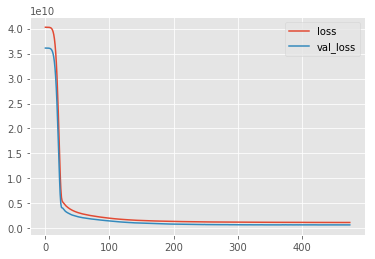

In [188]:
losses.plot()

In [189]:
NN_prediction = NN_model.predict(minmax_scaled_features_test)

In [190]:
print("MEAN RMS ERROR:", np.sqrt(mean_squared_error(y_test, NN_prediction)))

MEAN RMS ERROR: 26562.39854502119


Text(0, 0.5, 'Predicted cost ($)')

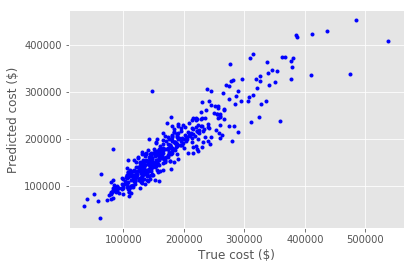

In [191]:
plt.plot(y_test, NN_prediction, 'b.')
plt.xlabel('True cost ($)')
plt.ylabel('Predicted cost ($)')

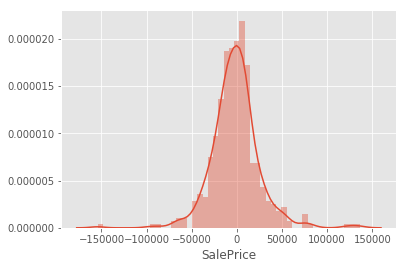

In [192]:
sns.distplot(y_test-NN_prediction.reshape(-1), bins=50)

# Looks to be between RAND FOREST, SVC and NN
Try on final test set

In [315]:
df_test_final = pd.read_csv('test.csv', index_col='Id')

In [316]:
nans = dict(df_test_final.isnull().sum())
for key in nans: print(key, nans[key])

MSSubClass 0
MSZoning 4
LotFrontage 227
LotArea 0
Street 0
Alley 1352
LotShape 0
LandContour 0
Utilities 2
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 1
Exterior2nd 1
MasVnrType 16
MasVnrArea 15
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 44
BsmtCond 45
BsmtExposure 44
BsmtFinType1 42
BsmtFinSF1 1
BsmtFinType2 42
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
Heating 0
HeatingQC 0
CentralAir 0
Electrical 0
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 2
BsmtHalfBath 2
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 1
TotRmsAbvGrd 0
Functional 2
Fireplaces 0
FireplaceQu 730
GarageType 76
GarageYrBlt 78
GarageFinish 78
GarageCars 1
GarageArea 1
GarageQual 78
GarageCond 78
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1456
Fence 1169
MiscFeature 1408
MiscVal 0
MoSold 0
YrSold 0

In [317]:
df_test_final = process_housing_df(df_test_final, datatype='test')

In [318]:
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OverallQual         1459 non-null   int64  
 1   OverallCond         1459 non-null   int64  
 2   YearBuilt           1459 non-null   int64  
 3   YearRemodAdd        1459 non-null   int64  
 4   MasVnrArea          1459 non-null   float64
 5   BsmtFinSF1          1459 non-null   float64
 6   BsmtFinSF2          1459 non-null   float64
 7   BsmtUnfSF           1459 non-null   float64
 8   TotalBsmtSF         1459 non-null   float64
 9   1stFlrSF            1459 non-null   int64  
 10  2ndFlrSF            1459 non-null   int64  
 11  GrLivArea           1459 non-null   int64  
 12  FullBath            1459 non-null   int64  
 13  BedroomAbvGr        1459 non-null   int64  
 14  TotRmsAbvGrd        1459 non-null   int64  
 15  Fireplaces          1459 non-null   int64  
 16  Gar

In [314]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 372 to 868
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OverallQual         970 non-null    int64  
 1   OverallCond         970 non-null    int64  
 2   YearBuilt           970 non-null    int64  
 3   YearRemodAdd        970 non-null    int64  
 4   MasVnrArea          970 non-null    float64
 5   BsmtFinSF1          970 non-null    int64  
 6   BsmtFinSF2          970 non-null    int64  
 7   BsmtUnfSF           970 non-null    int64  
 8   TotalBsmtSF         970 non-null    int64  
 9   1stFlrSF            970 non-null    int64  
 10  2ndFlrSF            970 non-null    int64  
 11  GrLivArea           970 non-null    int64  
 12  FullBath            970 non-null    int64  
 13  BedroomAbvGr        970 non-null    int64  
 14  TotRmsAbvGrd        970 non-null    int64  
 15  Fireplaces          970 non-null    int64  
 16  Garage

In [319]:
# this is annoying - I need to drop some extra cols that appear in final test set that aren't in the train set
# I can't even drop their na values as kaggle requires predictions size == number final test rows
df_test_final.drop(['MSZoning_C (all)', 'MasVnrType_BrkCmn', 'BsmtQual_Ex', 'KitchenQual_Ex', 'GarageFinish_Fin'],
                  axis=1, inplace=True)

In [320]:
# random forest
rforest_36 = RandomForestRegressor(n_estimators=36)
rforest_36.fit(X_train, y_train)
rforest_36_prediction = rforest_36.predict(df_test_final)

In [321]:
print(len(rforest_36_prediction))

1459


In [322]:
prediction_df = pd.DataFrame(rforest_36_prediction, df_test_final.index, columns=['SalePrice'] )

In [323]:
prediction_df.to_csv('house_prices_predictions.csv')